In [3]:
from SourceCode import *

Import all the packages used in the code

In [4]:
articles_df = pd.DataFrame()

## 0 Customize Search Scope
Specifying the period for which we want to extract the articles. 

In [5]:
start_year = 2010
end_year = 2018

## 1 Building a  Database of URLs for Articles

New York Times provide developers with search APIs to retrieve information from New York Times website. For this project's purposes, an Article Search API has been used. In order to get an API the programmer should make a request to NYT and to use that API, they should install the package *nytimesarticle*.

*The API key can be requested at: https://developer.nytimes.com/*

*The nytimesarticle package can be downloaded from: https://pypi.python.org/pypi/nytimesarticle/0.1.0*

there are two rate limits per API: 4,000 requests per day and 10 requests per minute. You should sleep 6 seconds between calls to avoid hitting the per minute rate limit.

Using Article Search API, one can search New York Times articles to retrieve the URL of the articles, their headlines, abstracts, lead paragraphs, associated multimedia, and other articles metadata. 

In [ ]:
api = articleAPI('FGeDkK80cnSAHqgvG6T3fhZZyeptr2Z1')

# Get Article URL List
articles_df = get_articles_url(api, start_year, end_year)
articles_df.tail()

As a result, the function returns a dataframe in which each row represents an article and contains its publishing date, url to the full article and number of words in the article. **Notice that the API does not return full body text of the articles**. Nevertheless, the URLs to the articles can be used to scrape the full text of the articles, on a later stage.

## 2 Scraping the Articles' Content
Now that we have a database of URLs of the articles, we can proceed to scrape each article's text. In order to do so, we should parse their HTML source using python modules (BeatifulSoup).

Analyzing many articles, it was found that developers in New York Times locate articles' body text under **p tags of class "story-body-text story-content"** or **p tags of class "css-1ygdjhk evys1bk0"**  or in earlier published articles under **p tags with an itemprop called "articleBody"**. Scarping of these p tags is carried out using BeautifulSoup module.

In [ ]:
# Get Article Text
articles_df = scrape_articles_text(articles_df)
articles_df.tail()

After calling the function *scarp_articles_text()*, the *articles_df* dataframe is expanded by adding a new column which includes all articles' body text for each article's URL collected in the previous step.

In [ ]:
articles_df=articles_df.drop_duplicates(subset=['url'], keep='last')
articles_df.to_csv('Articles_Sorted_Text.csv')

These lines of code remove the duplicate articles (which have the same URL) and save the dataframe into a csv file named "Articles_Sorted_Text.csv". After this stage, the following parts use this csv file to proceed with the rest of the code. 

In [6]:
articles_df = pd.read_csv('Articles_Sorted_Text.csv')
articles_df = articles_df[articles_df.columns[1:5]]
articles_df.tail()

,date,url,word_count,article_text
3362,2018-12-26,https://www.nytimes.com/2018/12/26/style/skin-...,1025,"In the beauty world, women of varied skin ton..."
3363,2018-12-26,https://www.nytimes.com/2018/12/26/well/eat/6-...,840,Below are some of our readers' favorite nutri...
3364,2018-12-28,https://www.nytimes.com/2018/12/28/arts/obama-...,811,Former President Barack Obama on Friday share...
3365,2018-12-29,https://www.nytimes.com/2018/12/28/us/politics...,811,WASHINGTON — In one of their final acts in th...
3366,2018-12-29,https://www.nytimes.com/2018/12/29/sports/socc...,1394,"LIVERPOOL, England — Jordan Henderson had jus..."


## 3 Text Mining

#### Text Pre-processing

Once the body text of each article is scraped, the next step is to transform it into a format amenable to analysis, in other words, break each article's body text into tokens. Tokenizing involves representing text as a list of words, numbers, symbols,etc which will become the input for machine learning algorithms. 

For this part, **nltk** package has been used to tokenize the texts and calculate TF (Term Frequency). In the following steps, IDF (inverse document frequency) and TF-IDF (TF mutiplied by IDF) are  also calculated using **sklearn** package. In this part, the following tasks have been carried out:  

1.	Tokenizing the articles into words and creating a list out of them.

2.  Removing undistinguished words from the list using **stopwords** method (words such as: I, You, the, an, these, those, are, is,etc). These words are common in almost every note and are not distictive of that note. 

3.	Stemming the words which translates to cutting off affixes in the words to consider just the stem of similar words. For example, all the words "work, working,worked, works" represent one concept, so instead of taking into account each of them seperately, only the stem of them "work" has been taken into consideration to develop the "Bag of Words".

4.  Calculating the term frequency of the words in the dictionary in each article. For example, if dictionary='Trump', term frequency for article(i) is equal to the number of times the word 'Trump' has been used in article(i) divided by the total number of words in article(i).

This example will look for the word **Trump** over the articles published from the year **2010** through **2018**. When visualizing the results in the end of text mining process, a high frequency of occurrence is expected only in time of election.

In [7]:
# Article pre-processing and word count
dictionary = 'Trump'
articles_df = text_mine_articles(articles_df, dictionary)
articles_df.tail()

Processing the text of the articles...
Done!


,date,url,word_count,article_text,num_occurr,freq_occurr
3362,2018-12-26,https://www.nytimes.com/2018/12/26/style/skin-...,1025,"In the beauty world, women of varied skin ton...",0,0.00000
3363,2018-12-26,https://www.nytimes.com/2018/12/26/well/eat/6-...,840,Below are some of our readers' favorite nutri...,0,0.00000
3364,2018-12-28,https://www.nytimes.com/2018/12/28/arts/obama-...,811,Former President Barack Obama on Friday share...,0,0.00000
3365,2018-12-29,https://www.nytimes.com/2018/12/28/us/politics...,811,WASHINGTON — In one of their final acts in th...,13,0.01603
3366,2018-12-29,https://www.nytimes.com/2018/12/29/sports/socc...,1394,"LIVERPOOL, England — Jordan Henderson had jus...",0,0.00000


By calling **text_mine_articles()** the function will add two columns to **articles_df**. The first added column **num_occurr** is the number of occurrences of the word in article(i) and the second added column **freq_occurr** is calculated as **num_occurr** /**word_count** .	

## 4 Presenting the Results

In order to obtain a better visualization of the results, all the articles have been re-arranged on a monthly basis.

In [8]:
# Re-arranging the data into a new dataframe on a monthly basis
results_df = get_monthly_results(articles_df, start_year, end_year)
results_df.tail()

Arranging the monthly results into a new dataframe...
Done!


,month_freq_occurr,num_articles,norm_freq_occurr
date,,,
2018-08-31,0.038799,33.0,0.001176
2018-09-30,0.106454,37.0,0.002877
2018-10-31,0.048375,35.0,0.001382
2018-11-30,0.086121,39.0,0.002208
2018-12-31,0.046516,30.0,0.001551


As the first result of the **get_monthly_results** function, all the calculated frequencies of occurance from previous steps for each article for the terms in the dictionary, are first accumulated to give a monthly frequency of occurrence presented as **month_freq_occurr**.The second result of this function is the total number of articles in each month presented as **num_articles**. Thereafter, the accumulated monthly frequency is normalized by dividing it by the total number of published articles in the corresponding month which is presented as **norm_freq_occurr**.

## 5 Visualize Results for this part

Once the previous 4 functions have been successfully called, the results are ready to be ploted.

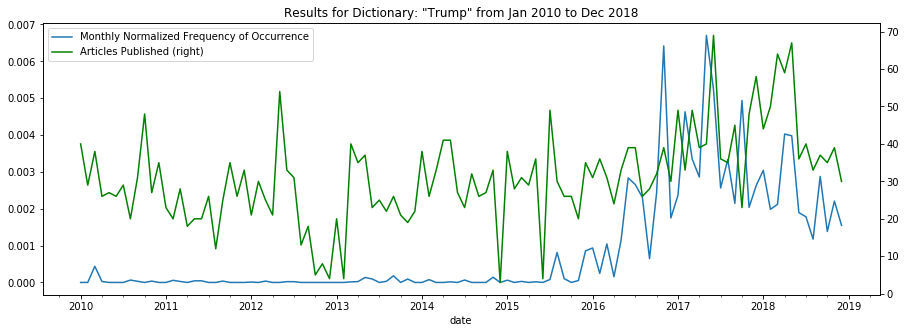

In [9]:
# Visualizing the Results
visualize_results(results_df, start_year, end_year, dictionary)

This plot shows the monthly term frequency of the word **Trump** in all the articles in a given month **(blue line)** and the total number of the articles in that month **(green line)**. As it is shown, Donuld Trump has been way out of the news from 2010 to early 2016. However form 2016 onwards, he has started getting attention in the news and the reason for this is the last presidency election of the United States in 2016. Cool!!!! 

## 6 "Bag of Words" and  appropriate data structure for machine learning algorithms

A **bag-of-words** is a representation of text that describes the occurrence of words within a document. It involves two things:

1. A **Vocabulary** of known words.
2. A **Measure of the Presence** of known words.

The measure for known words (words in the vocabulary) can be TF, TF-IDF, Word Count,etc. 

For the purpose of this section, **TfidfVectorizer()** and **CountVectorizer()** functions from **scikit-learn** package have been used. Each of these functions return a list of all the unique words (excluding the stop_words) in all the articles (**the Vocabulary**) and a musure for each word. The **TfidfVectorizer()** function returns the normalized (Euclidean norm) **TF-IDF** of a word as the **Measure** and the **CountVectorizer()** function returns **Word Count** of a word as the **Measure** for that word in the corresponding article. 

The following **Bag_of_Words** function ""prints"" the **Vocabulary** of all the articles and the shape of TF-IDF matrix whose rows represent all the articles and columns represent all the unique words in all the articles (the vocabulary). This function also ""returns"" the top 7 words of each article whose TF-IDF measure is more than all the words in the vocabulary. To get a better sense about the philosophy of what happens in this function, consider these 7 words in each article as the most important and distinctive words in it.

In [10]:
important_words, tfidf_df, count_df, Vocabulary = Bag_of_Words(articles_df)

In [11]:
print(Vocabulary)

['aa', 'aaa', 'aaaa', 'aaarena', 'aaarth', 'aadvantage', 'aage', 'aah', 'aahing', 'aalegra', 'aaliyah', 'aalto', 'aamer', 'aamir', 'aan', 'aardvarks', 'aarhus', 'aaron', 'aarons', 'aaronson', 'aarp', 'aas', 'aashish', 'aasif', 'ab', 'abaaoud', 'ababa', 'abac', 'aback', 'abacus', 'abadi', 'abady', 'abaire', 'aban', 'abandon', 'abandoned', 'abandoning', 'abandonment', 'abandons', 'abani', 'abaporu', 'abasement', 'abasementsonics', 'abashed', 'abasiama', 'abate', 'abated', 'abatement', 'abatements', 'abating', 'abaya', 'abba', 'abbado', 'abballa', 'abbas', 'abbasi', 'abbass', 'abbe', 'abbey', 'abbeys', 'abbi', 'abbie', 'abbot', 'abbots', 'abbott', 'abbottabad', 'abboud', 'abbr', 'abbreviate', 'abbreviated', 'abbreviation', 'abbreviations', 'abby', 'abc', 'abcs', 'abdalla', 'abdallah', 'abdel', 'abdelhamid', 'abdelkahar', 'abdellatif', 'abdelwahed', 'abdennour', 'abdeslam', 'abdicate', 'abdicated', 'abdication', 'abdomen', 'abdominal', 'abdominoplasty', 'abdu', 'abduct', 'abducted', 'abduc

In [12]:
# Finding the sparse-matrix of the TF-IDF DataFrame and  Count-Word DataFrame
tfidf_df_sparse=sparse.csr_matrix(tfidf_df)
CountWord_df_sparse=sparse.csr_matrix(count_df)

In [13]:
print(tfidf_df_sparse)

  (0, 600)	0.04874271054752939
  (0, 834)	0.09135856791559936
  (0, 1386)	0.06951964936863772
  (0, 1911)	0.014274640286153844
  (0, 2120)	0.020540825930046355
  (0, 2201)	0.022570649713805506
  (0, 2460)	0.03652100037463057
  (0, 2527)	0.050976914576038576
  (0, 2528)	0.05059206842256262
  (0, 2583)	0.1004408392520241
  (0, 2606)	0.04928748322621904
  (0, 3561)	0.07633294666934123
  (0, 4668)	0.01098774928100328
  (0, 4731)	0.020116027561210434
  (0, 6008)	0.17599782777927175
  (0, 6590)	0.02483361865943217
  (0, 6840)	0.0499499898832315
  (0, 6896)	0.06056960821494506
  (0, 8380)	0.07505633231337021
  (0, 8841)	0.09360412288593747
  (0, 10111)	0.05084710829846316
  (0, 10709)	0.060650233660208504
  (0, 10829)	0.04359548367820915
  (0, 11752)	0.07633294666934123
  (0, 12138)	0.102482572176024
  :	:
  (3366, 72106)	0.01769029574693284
  (3366, 72255)	0.016162283923561414
  (3366, 72557)	0.018815117056602864
  (3366, 73802)	0.017419758349714903
  (3366, 73992)	0.025720282595289842
  (33

In [14]:
print(CountWord_df_sparse)

  (0, 600)	1
  (0, 834)	1
  (0, 1386)	1
  (0, 1911)	1
  (0, 2120)	1
  (0, 2201)	1
  (0, 2460)	1
  (0, 2527)	1
  (0, 2528)	1
  (0, 2583)	2
  (0, 2606)	1
  (0, 3561)	1
  (0, 4668)	1
  (0, 4731)	1
  (0, 6008)	4
  (0, 6590)	1
  (0, 6840)	2
  (0, 6896)	2
  (0, 8380)	1
  (0, 8841)	2
  (0, 10111)	1
  (0, 10709)	1
  (0, 10829)	1
  (0, 11752)	1
  (0, 12138)	2
  :	:
  (3366, 72106)	1
  (3366, 72255)	1
  (3366, 72557)	1
  (3366, 73802)	1
  (3366, 73992)	1
  (3366, 74119)	2
  (3366, 74201)	1
  (3366, 74686)	2
  (3366, 74815)	1
  (3366, 74859)	1
  (3366, 74942)	1
  (3366, 75046)	1
  (3366, 75056)	3
  (3366, 75270)	1
  (3366, 75381)	1
  (3366, 75397)	1
  (3366, 75526)	1
  (3366, 75542)	1
  (3366, 75591)	4
  (3366, 75798)	1
  (3366, 75985)	2
  (3366, 75995)	1
  (3366, 75996)	2
  (3366, 76059)	2
  (3366, 76160)	1


In [15]:
#The top 7 most important words in each article Whose TF-IDF measure is more than the other words in the vocabulary
important_words[649:654]

,0,1,2,3,4,5,6
649,haymon,boxing,mayweather,brewster,promoters,simon,berto
650,iraq,afghanistan,obama,military,rhodes,foreign,multilateral
651,hammer,cable,usa,diller,syfy,ms,network
652,social,primate,species,structure,chapais,behavior,primates
653,nobel,committees,steinman,prize,swedish,hansson,prizes


In [16]:
articles_df['url'][653]

'https://www.nytimes.com/2011/12/20/health/when-the-honor-of-a-lifetime-a-nobel-prize-arrives-too-late.html'

## Summary and Conclusion

In the first 5 parts in this notebook, we ... :
1. Extracted the URL of New York Times articles using **Article Search API** offered by NYT website.
2. Scraped the text of each article using its URL.
3. Pre-processed the text of each article to calculate the TF (term frequency) of a certain word in each article.
4. Calculated the TF for the given word in all the articles and re-arranged the data on a monthly basis.
5. Visualized the results.

In the last part, we developed a list of unique words (the **Vocabulary**) in all the articles and ascribed a numerical feature to each word in each article (**TF-IDF** and **Word Count**). The list of unique words and the features attributed to each word in it for each article can be used as an input for machine learning algorithms to develop different tools.

## References

[1] https://scikit-learn.org/stable/modules/feature_extraction.html

[2] https://github.com/MattDMo/NYTimesArticleAPI

[3] https://dlab.berkeley.edu/blog/scraping-new-york-times-articles-python-tutorial

[4] https://github.com/nilmolne/Text-Mining-The-New-York-Times-Articles/tree/master/Code

[5] https://github.com/mayank408/TFIDF/blob/master/TFIDF.ipynb

[6] https://stackoverflow.com/questions/22289665/beautifulsoup-scraping-nytimes